In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
%matplotlib inline
import keras
from keras.optimizers import Adam
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU, Dropout, Activation, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import cv2
import re
import datetime
import skimage
import scipy #


from glob import glob
from IPython.display import Image

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [0]:
class DataLoader():
    def __init__(self, img_res=(256, 256)):
        self.img_res = img_res
        _URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

        path_to_zip = tf.keras.utils.get_file('facades.tar.gz',origin=_URL,extract=True)

        self.PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

    
    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path=os.path.join(self.PATH,'train') if not is_testing else os.path.join(self.PATH,'test')
        train_path = glob('%s/*.jpg' %(path))
#         label_path = glob('%s/*.png' %(data_path))
        batch_images = np.random.choice(train_path, size=batch_size)


        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = img_A = cv2.imread(img_path).astype(np.float)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]
#             h, w, _ = img.shape
#             _w = int(w/2)
#             img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            img_A = cv2.resize(img_A, self.img_res)
            img_B = cv2.resize(img_B, self.img_res)

            # If training => do random flip
            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        data_path=os.path.join(self.PATH,'train')
        train_path = glob('%s/*.jpg' %(data_path))

        self.n_batches = int(len(train_path) / batch_size)

        for i in range(self.n_batches-1):
            batch = train_path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = img_A = cv2.imread(img).astype(np.float)

                h, w, _ = img.shape
                _w = int(w/2)
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]

                img_A = cv2.resize(img_A, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)
                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

In [0]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.lossesmae = [[]]
        self.lossescross = [[]]
        self.lossesmsemae = [[]]
        self.lossescrossmae = [[]]
        # Configure data loader
        self.dataset_name = 'facades'
        self.data_loader = DataLoader()


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',optimizer=optimizer,metrics=['accuracy'])
        
        # Build the generator
        self.generator = self.build_generator()
        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
 #-------------------------------------------------------------------------------------------------       
        self.d = self.build_discriminator()
        self.d.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.g = self.build_generator()
        self.d.trainable = False
        v = self.d([fake_A, img_B])
        self.c = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[v, fake_A])
        self.c.compile(loss=['binary_crossentropy', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
#--------------------------------------------------------------------------------------------------        
        self.d1 = self.build_discriminator()
        self.d1.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.g1 = self.build_generator()
        self.d1.trainable = False
        v1 = self.d1([fake_A, img_B])

        self.c1 = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[v1, fake_A])
        self.c1.compile(loss='binary_crossentropy',
                              optimizer=optimizer)
#--------------------------------------------------------------------------------------------------        
        self.d2 = self.build_discriminator()
        self.d2.compile(loss='mae',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.g2 = self.build_generator()
        self.d2.trainable = False
        v2 = self.d2([fake_A, img_B])

        self.c2 = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[v2, fake_A])
        self.c2.compile(loss='mae',optimizer=optimizer)
#         imgsA, imgsB = self.data_loader.load_data(batch_size=16, is_testing=True)
#         history = self.c.fit(x=[imgsA, imgsB],y=[v, fake_A], validation_split=0.25, epochs=5, batch_size=16, verbose=1)
#         show_final_history(history,'crossentropy+mae')
#         history = self.c1.fit(x=[imgsA, imgsB],y=[v1, fake_A], validation_split=0.25, epochs=5, batch_size=16, verbose=1)
#         show_final_history(history, 'crossentropy')
#         history = self.c2.fit(x=[imgsA, imgsB],y=[v2, fake_A], validation_split=0.25, epochs=5, batch_size=16, verbose=1)
#         show_final_history(history, 'mae')
#         history = self.combined.fit(x=[imgsA, imgsB],y=[valid, fake_A], validation_split=0.25, epochs=5, batch_size=16, verbose=1)
#         show_final_history(history, 'mse+mae')
#############################################---------------------------------------------------------------------------    
    
  
    
    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = tf.keras.layers.Dropout(dropout_rate)(u)
            u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
            u = tf.keras.layers.Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = tf.keras.layers.Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
        output_img = tf.keras.layers.Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return tf.keras.models.Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = tf.keras.layers.Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return tf.keras.models.Model([img_A, img_B], validity)                
                    
                    
    def sample_images(self, string, epoch, batch_i):
        os.makedirs('./images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./images/%s/%s_%d_%d.png" % (self.dataset_name, string, epoch, batch_i))
        plt.close()
        
    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images('msemae',epoch, batch_i)
                    self.lossesmsemae.append((epoch*1000+batch_i,d_loss[0],g_loss[0]))
        
    def traincrossmae(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.g.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.d.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.d.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.c.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images('crossmae',epoch, batch_i)
                    self.lossescrossmae.append((epoch*1000+batch_i,d_loss[0],g_loss[0]))

    def traincross(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.g1.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.d1.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.d1.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.c1.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images('cross',epoch, batch_i)
                    self.lossescross.append((epoch*1000+batch_i,d_loss[0],g_loss[0]))
     
    def trainmae(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.g2.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.d2.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.d2.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.c2.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images('mae',epoch, batch_i)
                    self.lossesmae.append((epoch*1000+batch_i,d_loss[0],g_loss[0]))

In [0]:
gan = Pix2Pix()

30171136/30168306 [==============================] - 0s 0us/step


In [0]:
gan.train(epochs=20, batch_size=1, sample_interval=50)

[Epoch 0/20] [Batch 0/400] [D loss: 8.735828, acc:  40%] [G loss: 65.774811] time: 0:00:15.492630
[Epoch 0/20] [Batch 1/400] [D loss: 6.397056, acc:  49%] [G loss: 75.171234] time: 0:00:16.113004
[Epoch 0/20] [Batch 2/400] [D loss: 4.020234, acc:  52%] [G loss: 74.070107] time: 0:00:16.225146
[Epoch 0/20] [Batch 3/400] [D loss: 4.814974, acc:  43%] [G loss: 69.977219] time: 0:00:16.333169
[Epoch 0/20] [Batch 4/400] [D loss: 7.462454, acc:  40%] [G loss: 75.453003] time: 0:00:16.442099
[Epoch 0/20] [Batch 5/400] [D loss: 8.803869, acc:  47%] [G loss: 64.796555] time: 0:00:16.553241
[Epoch 0/20] [Batch 6/400] [D loss: 5.211657, acc:  51%] [G loss: 73.465965] time: 0:00:16.664585
[Epoch 0/20] [Batch 7/400] [D loss: 3.006280, acc:  50%] [G loss: 59.316299] time: 0:00:16.773150
[Epoch 0/20] [Batch 8/400] [D loss: 1.620013, acc:  53%] [G loss: 52.337730] time: 0:00:16.881978
[Epoch 0/20] [Batch 9/400] [D loss: 1.239327, acc:  52%] [G loss: 52.862667] time: 0:00:16.990502
[Epoch 0/20] [Batch 

In [0]:
gan.traincross(epochs=20, batch_size=1, sample_interval=50)

[Epoch 0/20] [Batch 0/400] [D loss: 7.949198, acc:  42%] [G loss: 5.924393] time: 0:00:05.558468
[Epoch 0/20] [Batch 1/400] [D loss: 7.314359, acc:  51%] [G loss: 2.453592] time: 0:00:05.918058
[Epoch 0/20] [Batch 2/400] [D loss: 7.502573, acc:  48%] [G loss: -0.058099] time: 0:00:06.031765
[Epoch 0/20] [Batch 3/400] [D loss: 8.296064, acc:  44%] [G loss: 4.433514] time: 0:00:06.146660
[Epoch 0/20] [Batch 4/400] [D loss: 7.169827, acc:  52%] [G loss: 3.958416] time: 0:00:06.258557
[Epoch 0/20] [Batch 5/400] [D loss: 7.668013, acc:  49%] [G loss: 1.911967] time: 0:00:06.367998
[Epoch 0/20] [Batch 6/400] [D loss: 7.367516, acc:  50%] [G loss: 4.794859] time: 0:00:06.477990
[Epoch 0/20] [Batch 7/400] [D loss: 7.828478, acc:  48%] [G loss: 4.883109] time: 0:00:06.591097
[Epoch 0/20] [Batch 8/400] [D loss: 7.294956, acc:  51%] [G loss: 4.279738] time: 0:00:06.702735
[Epoch 0/20] [Batch 9/400] [D loss: 7.555606, acc:  50%] [G loss: 4.332379] time: 0:00:06.818428
[Epoch 0/20] [Batch 10/400] [

In [0]:
gan.trainmae(epochs=20, batch_size=1, sample_interval=50)

[Epoch 0/20] [Batch 0/400] [D loss: 6.355315, acc:  41%] [G loss: 12.297968] time: 0:00:06.031549
[Epoch 0/20] [Batch 1/400] [D loss: 7.166844, acc:  49%] [G loss: 3.901188] time: 0:00:06.379300
[Epoch 0/20] [Batch 2/400] [D loss: 3.617663, acc:  45%] [G loss: 2.699663] time: 0:00:06.498408
[Epoch 0/20] [Batch 3/400] [D loss: 2.014173, acc:  49%] [G loss: 2.526285] time: 0:00:06.608583
[Epoch 0/20] [Batch 4/400] [D loss: 1.417491, acc:  42%] [G loss: 2.094984] time: 0:00:06.717630
[Epoch 0/20] [Batch 5/400] [D loss: 1.156639, acc:  49%] [G loss: 1.823619] time: 0:00:06.826829
[Epoch 0/20] [Batch 6/400] [D loss: 1.207421, acc:  50%] [G loss: 2.063576] time: 0:00:06.935690
[Epoch 0/20] [Batch 7/400] [D loss: 1.022873, acc:  57%] [G loss: 2.723137] time: 0:00:07.043038
[Epoch 0/20] [Batch 8/400] [D loss: 1.462265, acc:  43%] [G loss: 2.384048] time: 0:00:07.153524
[Epoch 0/20] [Batch 9/400] [D loss: 1.176470, acc:  49%] [G loss: 2.135308] time: 0:00:07.261475
[Epoch 0/20] [Batch 10/400] [

In [0]:
gan.traincrossmae(epochs=20, batch_size=1, sample_interval=50)

[Epoch 0/20] [Batch 0/400] [D loss: 8.065231, acc:  41%] [G loss: 32.333469] time: 0:00:06.861853
[Epoch 0/20] [Batch 1/400] [D loss: 7.724810, acc:  49%] [G loss: 85.420097] time: 0:00:07.203804
[Epoch 0/20] [Batch 2/400] [D loss: 7.771049, acc:  48%] [G loss: 71.131699] time: 0:00:07.318464
[Epoch 0/20] [Batch 3/400] [D loss: 7.663877, acc:  50%] [G loss: 49.842850] time: 0:00:07.429382
[Epoch 0/20] [Batch 4/400] [D loss: 7.667650, acc:  49%] [G loss: 55.111698] time: 0:00:07.537008
[Epoch 0/20] [Batch 5/400] [D loss: 8.558484, acc:  44%] [G loss: 56.943386] time: 0:00:07.646173
[Epoch 0/20] [Batch 6/400] [D loss: 7.694856, acc:  49%] [G loss: 67.856789] time: 0:00:07.754679
[Epoch 0/20] [Batch 7/400] [D loss: 7.913552, acc:  47%] [G loss: 47.209026] time: 0:00:07.862523
[Epoch 0/20] [Batch 8/400] [D loss: 7.943815, acc:  47%] [G loss: 57.192577] time: 0:00:07.969264
[Epoch 0/20] [Batch 9/400] [D loss: 7.674161, acc:  49%] [G loss: 51.498802] time: 0:00:08.076380
[Epoch 0/20] [Batch 

In [0]:
from google.colab import files
!zip -r piximages.zip /content/images


updating: content/images/ (stored 0%)
updating: content/images/facades/ (stored 0%)
updating: content/images/facades/cross_9_0.png (deflated 1%)
updating: content/images/facades/mae_2_350.png (deflated 1%)
updating: content/images/facades/mae_2_300.png (deflated 1%)
updating: content/images/facades/mae_10_350.png (deflated 1%)
updating: content/images/facades/cross_16_100.png (deflated 1%)
updating: content/images/facades/msemae_8_100.png (deflated 1%)
updating: content/images/facades/cross_5_350.png (deflated 1%)
updating: content/images/facades/mae_10_250.png (deflated 1%)
updating: content/images/facades/msemae_4_150.png (deflated 1%)
updating: content/images/facades/msemae_13_100.png (deflated 1%)
updating: content/images/facades/msemae_2_0.png (deflated 1%)
updating: content/images/facades/cross_14_0.png (deflated 1%)
updating: content/images/facades/msemae_11_100.png (deflated 1%)
updating: content/images/facades/cross_5_150.png (deflated 1%)
updating: content/images/facades/msem

In [0]:
# gan.lossescrossmae.remove([])
# gan.lossesmae.remove([])
# gan.lossescross.remove([])
# gan.lossesmsemae.remove([])
print(gan.lossesmae)

[(0, 6.3553147, 12.297968), (50, 1.3768888, 2.464575), (100, 0.52704865, 1.8087497), (150, 0.48320732, 1.4356016), (200, 0.5534663, 1.1064059), (250, 0.41673148, 1.125931), (300, 0.24056724, 1.2045122), (350, 0.27439997, 1.3996825), (1000, 0.32715735, 1.2294939), (1050, 0.3391589, 1.6030977), (1100, 0.19382784, 1.381261), (1150, 0.15882257, 0.97892326), (1200, 0.24697937, 0.8424816), (1250, 0.25101218, 0.91487014), (1300, 0.18259388, 1.0334061), (1350, 0.18648678, 1.3009979), (2000, 0.15450464, 1.1493704), (2050, 0.22002748, 1.2956916), (2100, 0.15514535, 1.3540069), (2150, 0.15068313, 0.94921196), (2200, 0.15055838, 0.7707652), (2250, 0.2307055, 0.84627944), (2300, 0.16551647, 0.9383726), (2350, 0.19209617, 1.2465502), (3000, 0.21522267, 1.0287076), (3050, 0.24316585, 1.1195978), (3100, 0.14424405, 1.3040841), (3150, 0.13005365, 0.93632394), (3200, 0.15658681, 0.7527043), (3250, 0.19917913, 0.9598053), (3300, 0.09775761, 0.87543094), (3350, 0.10276322, 1.2430947), (4000, 0.12723765, 1

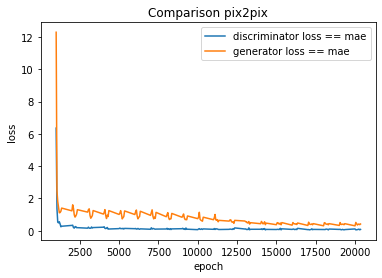

In [0]:
x=[xi[0]+1000 for xi in gan.lossesmae]
y=[xi[1] for xi in gan.lossesmae]
z=[xi[2] for xi in gan.lossesmae]
plt.plot(x,y,label='discriminator loss == mae')
plt.plot(x,z,label='generator loss == mae')
# x1=[xi[0]+1000 for xi in gan.lossescross]
# y1=[xi[1] for xi in gan.lossescross]
# z1=[xi[2] for xi in gan.lossescross]
# plt.plot(y1,x1,label='discriminator loss == cross entropy')
# plt.plot(z1,x1,label='generator loss == cross entropy')
# x2=[xi[0]+1000 for xi in gan.lossescrossmae]
# y2=[xi[1] for xi in gan.lossescrossmae]
# z2=[xi[2] for xi in gan.lossescrossmae]
# plt.plot(y2,x2,label='discriminator loss == cross entropy + mae')
# plt.plot(z2,x2,label='generator loss == cross entropy + mae')
# x3=[xi[0]+1000 for xi in gan.lossesmsemae]
# y3=[xi[1] for xi in gan.lossesmsemae]
# z3=[xi[2] for xi in gan.lossesmsemae]
# plt.plot(y3,x3,label='discriminator loss == mse + mae')
# plt.plot(z3,x3,label='generator loss == mse + mae')
plt.legend()
plt.title('Comparison pix2pix')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Lossmae.png')

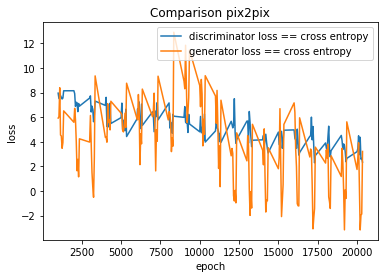

In [0]:
x1=[xi[0]+1000 for xi in gan.lossescross]
y1=[xi[1] for xi in gan.lossescross]
z1=[xi[2] for xi in gan.lossescross]
plt.plot(x1,y1,label='discriminator loss == cross entropy')
plt.plot(x1,z1,label='generator loss == cross entropy')
# x2=[xi[0]+1000 for xi in gan.lossescrossmae]
# y2=[xi[1] for xi in gan.lossescrossmae]
# z2=[xi[2] for xi in gan.lossescrossmae]
# plt.plot(y2,x2,label='discriminator loss == cross entropy + mae')
# plt.plot(z2,x2,label='generator loss == cross entropy + mae')
# x3=[xi[0]+1000 for xi in gan.lossesmsemae]
# y3=[xi[1] for xi in gan.lossesmsemae]
# z3=[xi[2] for xi in gan.lossesmsemae]
# plt.plot(y3,x3,label='discriminator loss == mse + mae')
# plt.plot(z3,x3,label='generator loss == mse + mae')
plt.legend()
plt.title('Comparison pix2pix')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Losscross.png')

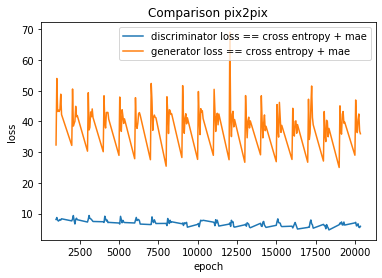

In [0]:
x2=[xi[0]+1000 for xi in gan.lossescrossmae]
y2=[xi[1] for xi in gan.lossescrossmae]
z2=[xi[2] for xi in gan.lossescrossmae]
plt.plot(x2,y2,label='discriminator loss == cross entropy + mae')
plt.plot(x2,z2,label='generator loss == cross entropy + mae')
# x3=[xi[0]+1000 for xi in gan.lossesmsemae]
# y3=[xi[1] for xi in gan.lossesmsemae]
# z3=[xi[2] for xi in gan.lossesmsemae]
# plt.plot(y3,x3,label='discriminator loss == mse + mae')
# plt.plot(z3,x3,label='generator loss == mse + mae')
plt.legend()
plt.title('Comparison pix2pix')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Losscrossmae.png')

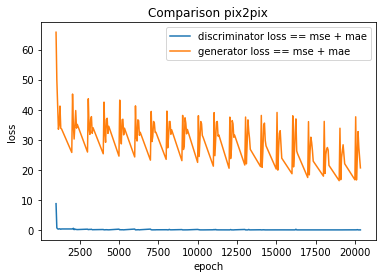

In [0]:
x3=[xi[0]+1000 for xi in gan.lossesmsemae]
y3=[xi[1] for xi in gan.lossesmsemae]
z3=[xi[2] for xi in gan.lossesmsemae]
plt.plot(x3,y3,label='discriminator loss == mse + mae')
plt.plot(x3,z3,label='generator loss == mse + mae')
plt.legend()
plt.title('Comparison pix2pix')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('Lossmsemae.png')

In [0]:
from google.colab import files
!zip -r piximages1.zip /content/images
